<a href="https://colab.research.google.com/github/rht6226/InnoHAR-NeuralNet/blob/master/CNN_LSTM_based_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN-LSTM based Model


In this module we will be training a model which uses the CNN-LSTM based Architecture for Human Activity recognition on UCI HAR Mobile Dataset. 

In [1]:
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

## Loading the dataset

In [2]:
# Get class from file
from drive.MyDrive.InnoHAR.DatasetLoader import UciMobileDataset

In [3]:
uci = UciMobileDataset(filepath='/content/drive/MyDrive/InnoHAR/ProcessedDataset/')
uci.summary()

UCI Human Activity Recognition Dataset: 
Shape of training data = X:(7352, 128, 9), y: (7352, 6)
Shape of testing data = X:(2947, 128, 9), y: (2947, 6)


## Creating the Model

The CNN LSTM model will read subsequences of the main sequence in as blocks, extract features from each block, then allow the LSTM to interpret the features extracted from each block.

One approach to implementing this model is to split each window of 128 time steps into subsequences for the CNN model to process. For example, the 128 time steps in each window can be split into four subsequences of 32 time steps.

In [4]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.utils.vis_utils import plot_model

In [5]:
# Split the dataset from timesteps of 128 to 4 subsequences of size 32 each
n_steps, n_length = 4, 32
n_features, n_outputs = uci.trainX.shape[2] , uci.trainy.shape[1]
trainX = uci.trainX.reshape((uci.trainX.shape[0], n_steps, n_length, n_features))
testX = uci.testX.reshape((uci.testX.shape[0], n_steps, n_length, n_features))

In [6]:
print("Reshaped the trainX data from {} to : {}".format(uci.trainX.shape, trainX.shape))
print("Reshaped the testX data from {} to : {}".format(uci.testX.shape, testX.shape))

Reshaped the trainX data from (7352, 128, 9) to : (7352, 4, 32, 9)
Reshaped the testX data from (2947, 128, 9) to : (2947, 4, 32, 9)


The entire CNN model can be wrapped in a TimeDistributed layer to allow the same CNN model to read in each of the four subsequences in the window. The extracted features are then flattened and provided to the LSTM model to read, extracting its own features before a final mapping to an activity is made.

In [7]:
def get_cnn_lstm_model(n_length, n_features, n_outputs):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [8]:
# Model summary
model_cnn_lstm = get_cnn_lstm_model(n_length, n_features, n_outputs)
model_cnn_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 896)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               398800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

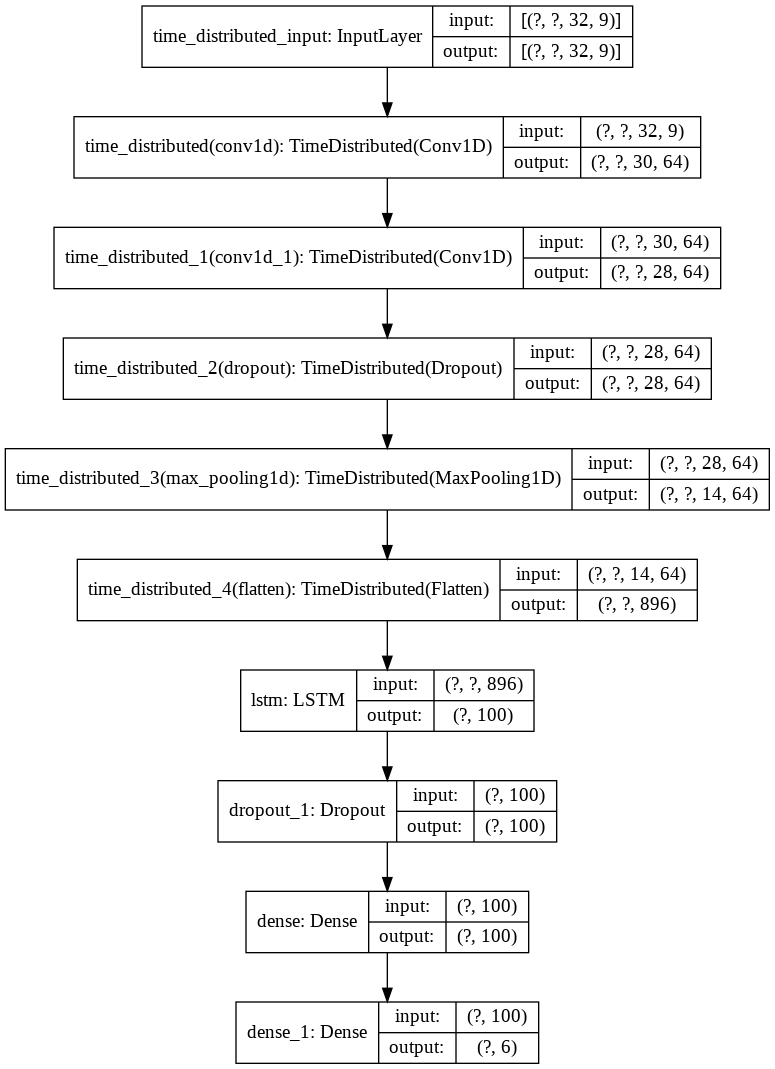

In [9]:
plot_model(model=model_cnn_lstm, show_layer_names=True, show_shapes=True)

## Training the Models

Only one instance of a trained model cannot be used to determine the model performance. Hence we will be training Multiple instances of the same CNN-LSTM model and then we will find out the average accuracy.

In [10]:
def train_models(X=trainX, y=uci.trainy, num_instances=50, verbose=1, epochs=25, batch_size=64, valid_data = (testX, uci.testy)):

    # Here we will store all the models
    modelList = []

    # Training multiple models at the same time for finding average accuracy
    for i in range(num_instances):
        print("\n<========== Now training model - {} ...... =======>".format(i))

        model = get_cnn_lstm_model(n_length, n_features, n_outputs)
        history = model.fit(X, y, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=valid_data)

        print("<==================================================>\n")

        # Finding accuracy
        _, accuracy = model.evaluate(valid_data[0], valid_data[1], batch_size=32, verbose=0)

        modelList.append({
            "model": model,
            "history": history,
            "accuracy": accuracy
        })

    return modelList

In [11]:
epochs, batch_size = 25, 64
modelList = train_models(epochs=epochs, batch_size=batch_size)


<========== Now training model - 0 ...... =======>
Epoch 1/25
115/115 [==============================] - 1s 10ms/step - loss: 0.6079 - accuracy: 0.7473 - val_loss: 0.6309 - val_accuracy: 0.7350
Epoch 2/25
115/115 [==============================] - 1s 6ms/step - loss: 0.2405 - accuracy: 0.9116 - val_loss: 0.3499 - val_accuracy: 0.8806
Epoch 3/25
115/115 [==============================] - 1s 6ms/step - loss: 0.1495 - accuracy: 0.9410 - val_loss: 0.2911 - val_accuracy: 0.8928
Epoch 4/25
115/115 [==============================] - 1s 6ms/step - loss: 0.1345 - accuracy: 0.9483 - val_loss: 0.3853 - val_accuracy: 0.8728
Epoch 5/25
115/115 [==============================] - 1s 6ms/step - loss: 0.1171 - accuracy: 0.9493 - val_loss: 0.2820 - val_accuracy: 0.9036
Epoch 6/25
115/115 [==============================] - 1s 6ms/step - loss: 0.1173 - accuracy: 0.9518 - val_loss: 0.3224 - val_accuracy: 0.9101
Epoch 7/25
115/115 [==============================] - 1s 6ms/step - loss: 0.1083 - accuracy: 0.

# Compare different instances

We will compare the different instances of trained model to find the one which gives the best performance. We will also find the average accuracy for the trained models.

In [12]:
# Imports
import matplotlib.pyplot as plt
from statistics import mean 

In [13]:
def plot_accuracies(modelList, modelName, figureSize=[8, 8]):
    accuracies = []
    for modelDict in modelList:
        accuracies.append(modelDict['accuracy'])
    mean_accuracy = mean(accuracies)
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(accuracies)
    plt.axhline(y=mean_accuracy, color='r', linestyle='-')
    plt.title('Model accuracy for different instances of - {}'.format(modelName))
    plt.ylabel('accuracy')
    plt.xlabel('Instance #')
    plt.legend(['Instance Accuracy', 'Mean Accuracy'], loc='lower right')
    plt.show()
    
    print("\n\nThe average accuracy of this model was found out to be: {}".format(mean_accuracy))

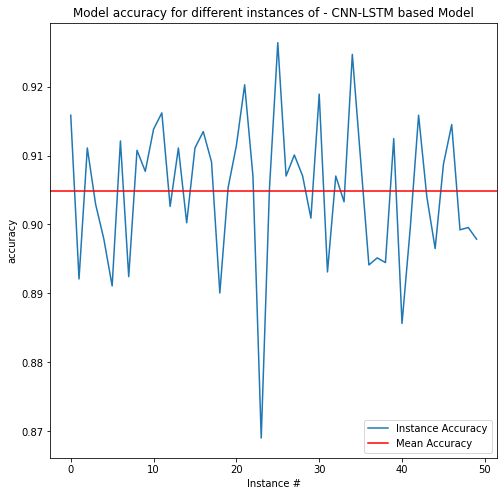



The average accuracy of this model was found out to be: 0.9049066865444183


In [14]:
plot_accuracies(modelList, modelName='CNN-LSTM based Model')

## Selecting Model closest to Mean

here we will be selecting a model instance whose performance is the closest to the mean accuracy. This will help us in comparision between various models.

In [15]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import get_average_model

In [16]:
model, history = get_average_model(modelList)

In [17]:
## Save Model
model.save('/content/drive/MyDrive/InnoHAR/SavedModels/CNN_LSTM.h5')

## Plotting Accuracy and Losses

In [18]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import plot_model_accuracy, plot_model_loss

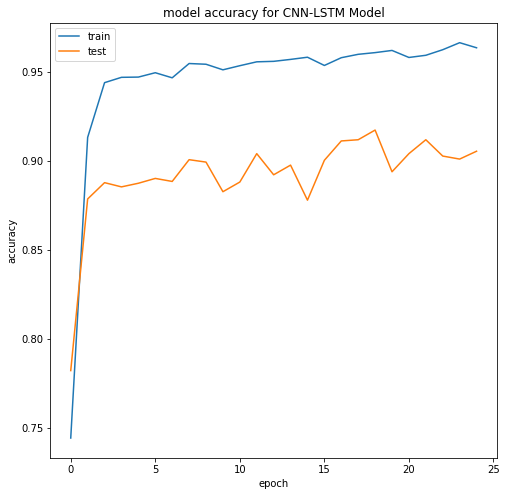

In [19]:
plot_model_accuracy('CNN-LSTM Model', history=history)

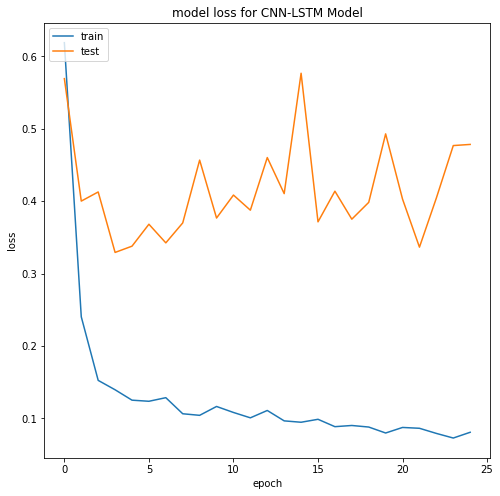

In [20]:
plot_model_loss('CNN-LSTM Model', history=history)

## Plotting Confusion Matrix

In [21]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import plot_cm

Confusion matrix, without normalization


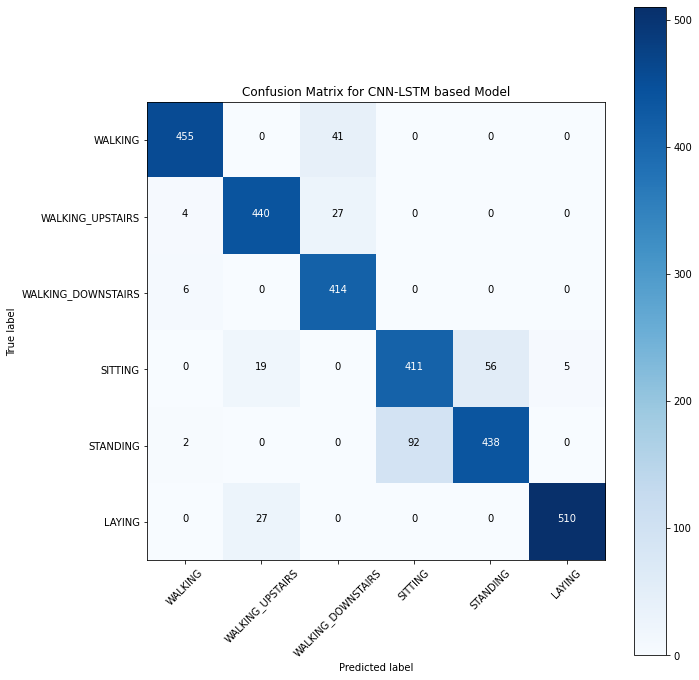

In [23]:
plot_cm(model, test_data=(testX, uci.testy), title='Confusion Matrix for CNN-LSTM based Model')

## Classification Report

In [24]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import print_classification_report

In [25]:
print_classification_report(model, test_data=(testX, uci.testy), title='CNN-LSTM Model')

Classification Report for 'CNN-LSTM Model': 

                    precision    recall  f1-score   support

           WALKING    0.97430   0.91734   0.94496       496
  WALKING_UPSTAIRS    0.90535   0.93418   0.91954       471
WALKING_DOWNSTAIRS    0.85892   0.98571   0.91796       420
           SITTING    0.81710   0.83707   0.82696       491
          STANDING    0.88664   0.82331   0.85380       532
            LAYING    0.99029   0.94972   0.96958       537

          accuracy                        0.90533      2947
         macro avg    0.90543   0.90789   0.90547      2947
      weighted avg    0.90773   0.90533   0.90542      2947

